<a href="https://colab.research.google.com/github/saokotie/Applied-Machine-Learning/blob/main/04_skin_disease_efficientnetb0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# %% [setup]
import os, sys, json, random, shutil, zipfile, math, time
from pathlib import Path
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, EfficientNetB0
from tensorflow.keras.applications.resnet import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print('TensorFlow', tf.__version__)

BASE_DIR = Path('.').resolve()
OUTPUT_DIR = Path('./outputs')
PREP_DIR = OUTPUT_DIR / 'skindisease_preprocessed'
MODEL_DIR = OUTPUT_DIR / 'models'
METRIC_DIR = OUTPUT_DIR / 'metrics'

for d in [OUTPUT_DIR, PREP_DIR, MODEL_DIR, METRIC_DIR]:
    d.mkdir(parents=True, exist_ok=True)


print('Physical GPUs', tf.config.list_physical_devices('GPU'))

# %% [data-acquisition]
from pathlib import Path

CANDIDATES = [
    Path('/content/drive/MyDrive/COM6404-Applied-Machine-Learning/SkinDisease')
]

DATA_ROOT = None
for p in CANDIDATES:
    if (p/'train').exists() and (p/'test').exists():
        DATA_ROOT = p
        break

if DATA_ROOT is None:
    print('none')
else:
    print('DATA_ROOT =', DATA_ROOT.resolve())
    print('Train dir =', (DATA_ROOT/'train').resolve())
    print('Test dir =', (DATA_ROOT/'test').resolve())

TensorFlow 2.19.0
Physical GPUs [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
DATA_ROOT = /content/drive/MyDrive/COM6404-Applied-Machine-Learning/SkinDisease
Train dir = /content/drive/MyDrive/COM6404-Applied-Machine-Learning/SkinDisease/train
Test dir = /content/drive/MyDrive/COM6404-Applied-Machine-Learning/SkinDisease/test


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Train images, 13898 kelas, 22
Test images, 1546 kelas, 22


,filepath,label
0,/kaggle/input/skindiseasedataset/SkinDisease/S...,Acne
1,/kaggle/input/skindiseasedataset/SkinDisease/S...,Acne
2,/kaggle/input/skindiseasedataset/SkinDisease/S...,Acne
3,/kaggle/input/skindiseasedataset/SkinDisease/S...,Acne
4,/kaggle/input/skindiseasedataset/SkinDisease/S...,Acne


,count
label,
Unknown_Normal,1651
Benign_tumors,1093
Eczema,1010
Tinea,923
Psoriasis,820
Actinic_Keratosis,748
Vitiligo,714
SkinCancer,693
Acne,593


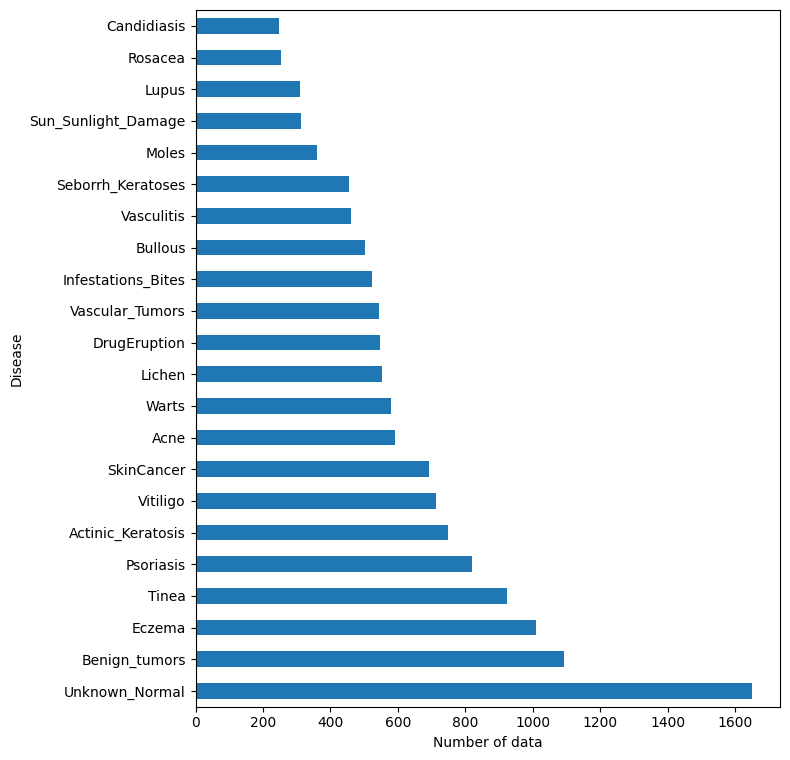

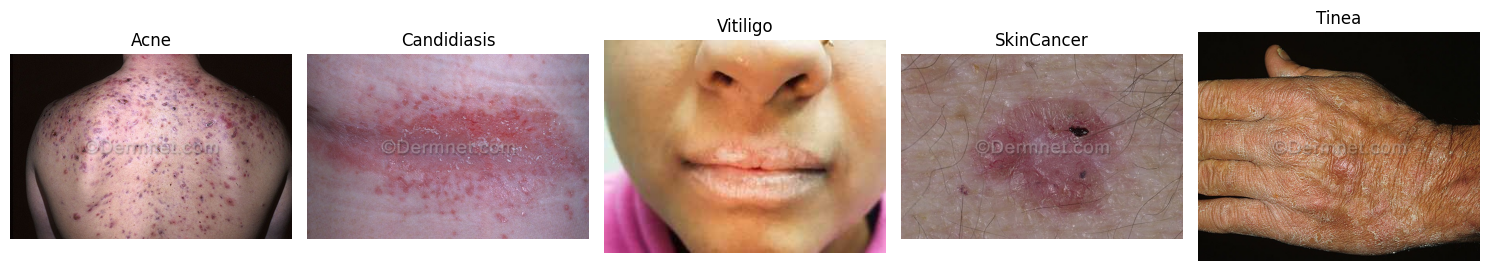

In [ ]:
# %% [data-understanding]
import pandas as pd

def scan_split(root_dir: Path):
    items = []
    for cls_dir in sorted([d for d in root_dir.iterdir() if d.is_dir()]):
        label = cls_dir.name
        for img_path in cls_dir.rglob('*'):
            if img_path.suffix.lower() in {'.jpg','.jpeg','.png','.bmp','.gif'} and img_path.is_file():
                items.append((img_path, label))
    return pd.DataFrame(items, columns=['filepath','label'])

if DATA_ROOT is not None:
    train_src = DATA_ROOT/'train'
    test_src  = DATA_ROOT/'test'
    df_train_src = scan_split(train_src)
    df_test_src  = scan_split(test_src)

    print('Train images,', len(df_train_src), 'kelas,', df_train_src["label"].nunique())
    print('Test images,', len(df_test_src), 'kelas,', df_test_src["label"].nunique())

    display(df_train_src.head())
    display(df_train_src['label'].value_counts().to_frame('count'))
else:
    df_train_src = pd.DataFrame(columns=['filepath','label'])
    df_test_src = pd.DataFrame(columns=['filepath','label'])

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import random


if len(df_train_src) > 0:
    cls_counts = df_train_src['label'].value_counts().sort_values(ascending=False)
    plt.figure()
    cls_counts.plot(kind='barh', figsize=(8, max(3, 0.35*len(cls_counts))))
    plt.xlabel('Number of data')
    plt.ylabel('Disease')
    plt.tight_layout()
    plt.show()


def visualize_samples_df(df, n=5):
    n = min(n, len(df))
    if n == 0:

        return
    rows = df.sample(n=n, random_state=42)
    fig, axes = plt.subplots(1, n, figsize=(3*n, 3))
    if n == 1:
        axes = [axes]
    for ax, (_, row) in zip(axes, rows.iterrows()):
        try:
            img = Image.open(row['filepath']).convert('RGB')
            ax.imshow(img)
            ax.set_title(str(row['label']))
            ax.axis('off')
        except Exception as e:
            ax.axis('off')
            ax.set_title('Gagal load')
    plt.tight_layout()
    plt.show()

visualize_samples_df(df_train_src, n=5)

In [ ]:
# %% [preprocess]
from sklearn.model_selection import train_test_split
from PIL import Image
import zipfile, shutil
from pathlib import Path

IMG_SIZE = (224, 224)
VAL_SIZE = 0.15
BATCH_SIZE = 32

assert 'df_train_src' in globals() and len(df_train_src) > 0, "df_train_src belum tersedia"
assert 'df_test_src'  in globals(), "df_test_src belum tersedia"

OUTPUT_DIR = Path('./outputs')
PREP_DIR = OUTPUT_DIR / 'skindisease_preprocessed'

shutil.rmtree(PREP_DIR, ignore_errors=True)
PREP_DIR.mkdir(parents=True, exist_ok=True)

train_df, val_df = train_test_split(
    df_train_src,
    test_size=VAL_SIZE,
    stratify=df_train_src['label'],
    random_state=42
)

def save_resized(df_split, split_name):
    split_dir = PREP_DIR / split_name
    for _, row in df_split.iterrows():
        src = Path(row['filepath'])
        label = str(row['label']) if 'label' in row else src.parent.name
        dst_dir = split_dir / label
        dst_dir.mkdir(parents=True, exist_ok=True)
        dst = dst_dir / src.name
        try:
            img = Image.open(src).convert('RGB')
            img = img.resize(IMG_SIZE, Image.BILINEAR)
            img.save(dst)
        except Exception:
            pass

save_resized(train_df, 'train')
save_resized(val_df,   'val')
save_resized(df_test_src, 'test')

print('Sumber Train asli,', len(df_train_src), 'gambar')
print('Split baru,', len(train_df), 'train,', len(val_df), 'val,', len(df_test_src), 'test')

zip_path = OUTPUT_DIR / 'skindisease_preprocessed.zip'
with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zf:
    for p in PREP_DIR.rglob('*'):
        if p.is_file():
            zf.write(p, p.relative_to(OUTPUT_DIR))
print('Arsip preprocessed,', zip_path.resolve())

Sumber Train asli, 13898 gambar
Split baru, 11813 train, 2085 val, 1546 test
Arsip preprocessed, /kaggle/working/outputs/skindisease_preprocessed.zip


In [ ]:
# %% [pipeline]
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import json
from pathlib import Path

OUTPUT_DIR = Path('./outputs')
PREP_DIR = OUTPUT_DIR / 'skindisease_preprocessed'
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

def make_generators(preprocess_fn):
    train_gen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.15,
        height_shift_range=0.15,
        zoom_range=0.2,
        horizontal_flip=True,
        brightness_range=[0.8, 1.2],
        shear_range=0.1,
        fill_mode='nearest',
        preprocessing_function=preprocess_fn
    )

    valid_gen = ImageDataGenerator(preprocessing_function=preprocess_fn)
    test_gen  = ImageDataGenerator(preprocessing_function=preprocess_fn)

    train_flow = train_gen.flow_from_directory(
        PREP_DIR/'train',
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True,
        seed=42
    )
    val_flow = valid_gen.flow_from_directory(
        PREP_DIR/'val',
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )
    test_flow = test_gen.flow_from_directory(
        PREP_DIR/'test',
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )
    return train_flow, val_flow, test_flow

if (PREP_DIR/'train').exists():
    tmp_flow = ImageDataGenerator().flow_from_directory(PREP_DIR/'train', target_size=IMG_SIZE, batch_size=32, class_mode='categorical')
    class_indices = tmp_flow.class_indices
    inv_class_indices = {v:k for k,v in class_indices.items()}
    with open(OUTPUT_DIR/'class_indices.json', 'w') as f:
        json.dump({'class_indices': class_indices, 'inv_class_indices': inv_class_indices}, f, indent=2)
    print('class_indices', class_indices)
else:
    class_indices = {}
    inv_class_indices = {}

Found 11813 images belonging to 22 classes.
class_indices {'Acne': 0, 'Actinic_Keratosis': 1, 'Benign_tumors': 2, 'Bullous': 3, 'Candidiasis': 4, 'DrugEruption': 5, 'Eczema': 6, 'Infestations_Bites': 7, 'Lichen': 8, 'Lupus': 9, 'Moles': 10, 'Psoriasis': 11, 'Rosacea': 12, 'Seborrh_Keratoses': 13, 'SkinCancer': 14, 'Sun_Sunlight_Damage': 15, 'Tinea': 16, 'Unknown_Normal': 17, 'Vascular_Tumors': 18, 'Vasculitis': 19, 'Vitiligo': 20, 'Warts': 21}


In [ ]:
# %% [modeling-utils]
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

OUTPUT_DIR = Path('./outputs')
MODEL_DIR = OUTPUT_DIR / 'models'
METRIC_DIR = OUTPUT_DIR / 'metrics'
MODEL_DIR.mkdir(parents=True, exist_ok=True)
METRIC_DIR.mkdir(parents=True, exist_ok=True)

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

def build_efficientnet_model(input_shape, n_classes):
    """Build optimized EfficientNetB0 model for better accuracy and faster training"""

    base_model = EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape + (3,),
        pooling='avg'
    )

    base_model.trainable = True

    total_layers = len(base_model.layers)
    freeze_until = int(0.8 * total_layers)

    print(f"Total layers: {total_layers}")
    print(f"Freezing first {freeze_until} layers")

    for i, layer in enumerate(base_model.layers):
        if i < freeze_until:
            layer.trainable = False
        else:
            layer.trainable = True

    inputs = layers.Input(shape=input_shape + (3,))
    x = base_model(inputs, training=True)


    x = layers.Dropout(0.3)(x)
    x = layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(n_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs, name='efficientnet_optimized')
    return model, efficientnet_preprocess

def compile_model(model, lr=1e-3):
    """Compile model with optimized settings for EfficientNet"""
    opt = tf.keras.optimizers.Adam(
        learning_rate=lr,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07
    )

    model.compile(
        optimizer=opt,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

def plot_training_history(history, model_tag):
    """Plot accuracy and loss charts for training"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Accuracy
    axes[0].plot(history['accuracy'], label='Training Accuracy', linewidth=2)
    if 'val_accuracy' in history:
        axes[0].plot(history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    axes[0].set_title(f'{model_tag} - Training & Validation Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Loss
    axes[1].plot(history['loss'], label='Training Loss', linewidth=2)
    if 'val_loss' in history:
        axes[1].plot(history['val_loss'], label='Validation Loss', linewidth=2)
    axes[1].set_title(f'{model_tag} - Training & Validation Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(METRIC_DIR/f'{model_tag}_training_history.png', dpi=150, bbox_inches='tight')
    plt.show()

def plot_confusion_matrix_with_numbers(cm, target_names, model_tag):
    """Plot confusion matrix with numbers annotated in each cell"""
    plt.figure(figsize=(10, 8))

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names,
                yticklabels=target_names,
                cbar_kws={'label': 'Number of Samples'},
                annot_kws={'size': 10, 'weight': 'bold'})

    plt.title(f'Confusion Matrix - {model_tag}', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
    plt.ylabel('True Label', fontsize=12, fontweight='bold')

    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(rotation=0, fontsize=10)

    plt.tight_layout()
    plt.savefig(METRIC_DIR/f'{model_tag}_confusion_matrix_annotated.png', dpi=150, bbox_inches='tight')
    plt.show()

def print_classification_report(cls_report, model_tag):
    """Print formatted classification report"""
    print(f"\n{'='*60}")
    print(f"CLASSIFICATION REPORT - {model_tag.upper()}")
    print(f"{'='*60}")

    report_df = pd.DataFrame(cls_report).transpose()

    metrics_to_show = ['precision', 'recall', 'f1-score', 'support']
    display_cols = [col for col in metrics_to_show if col in report_df.columns]

    print("\nDetailed Report:")
    display(report_df[display_cols].round(4))

    if 'accuracy' in cls_report:
        print(f"\nOverall Accuracy: {cls_report['accuracy']:.4f}
    if 'macro avg' in cls_report:
        macro_avg = cls_report['macro avg']
        print(f"\nMacro Average:")
        print(f"  Precision: {macro_avg['precision']:.4f}")
        print(f"  Recall:    {macro_avg['recall']:.4f}")
        print(f"  F1-Score:  {macro_avg['f1-score']:.4f}")

    if 'weighted avg' in cls_report:
        weighted_avg = cls_report['weighted avg']
        print(f"\nWeighted Average:")
        print(f"  Precision: {weighted_avg['precision']:.4f}")
        print(f"  Recall:    {weighted_avg['recall']:.4f}")
        print(f"  F1-Score:  {weighted_avg['f1-score']:.4f}")

def train_efficientnet_model(model, preprocess_fn, model_tag, epochs=25, lr=1e-3):
    """Single-phase optimized training for EfficientNet with better accuracy and faster convergence"""
    train_flow, val_flow, test_flow = make_generators(preprocess_fn)
    n_classes = train_flow.num_classes

    model = compile_model(model, lr=lr)

    callbacks = [
        EarlyStopping(
            monitor='val_accuracy',
            patience=10,
            restore_best_weights=True,
            verbose=1,
            mode='max'
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-7,
            verbose=1
        ),
        ModelCheckpoint(
            str(MODEL_DIR/f'{model_tag}_best.keras'),
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1,
            mode='max'
        )
    ]

    print(f"Starting optimized training for {model_tag}...")
    print(f"Training samples: {train_flow.samples}")
    print(f"Validation samples: {val_flow.samples}")
    print(f"Test samples: {test_flow.samples}")
    print(f"Number of classes: {n_classes}")
    print(f"Total model parameters: {model.count_params():,}")

    trainable_params = np.sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
    non_trainable_params = np.sum([tf.keras.backend.count_params(w) for w in model.non_trainable_weights])
    print(f"Trainable parameters: {trainable_params:,}")
    print(f"Non-trainable parameters: {non_trainable_params:,}")

    history = model.fit(
        train_flow,
        validation_data=val_flow,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )

    plot_training_history(history.history, model_tag)

    test_results = model.evaluate(test_flow, verbose=0)
    test_loss = test_results[0]
    test_accuracy = test_results[1]

    print(f"\nTest Accuracy: {test_accuracy:.4f}")
    print(f"Test Loss: {test_loss:.4f}")

    test_flow.reset()
    y_prob = model.predict(test_flow, verbose=0)
    y_pred = np.argmax(y_prob, axis=1)
    y_true = test_flow.classes
    target_names = list(test_flow.class_indices.keys())

    from sklearn.metrics import classification_report, confusion_matrix
    cls_report = classification_report(y_true, y_pred, target_names=target_names, output_dict=True, zero_division=0)
    cm = confusion_matrix(y_true, y_pred)

    pd.DataFrame(history.history).to_csv(METRIC_DIR/f'{model_tag}_training_history.csv', index=False)
    pd.DataFrame(cm, index=target_names, columns=target_names).to_csv(METRIC_DIR/f'{model_tag}_confusion_matrix.csv')
    pd.DataFrame(cls_report).T.to_csv(METRIC_DIR/f'{model_tag}_classification_report.csv')

    results = {
        'test_loss': float(test_loss),
        'test_accuracy': float(test_accuracy),
        'classification_report': cls_report,
        'confusion_matrix': cm.tolist(),
        'target_names': target_names,
        'training_epochs': len(history.history['accuracy']),
        'final_train_accuracy': float(history.history['accuracy'][-1]),
        'final_val_accuracy': float(history.history['val_accuracy'][-1]),
        'total_parameters': model.count_params(),
        'trainable_parameters': int(trainable_params),
        'non_trainable_parameters': int(non_trainable_params)
    }

    with open(METRIC_DIR/f'{model_tag}_results.json','w') as f:
        json.dump(results, f, indent=2)

    plot_confusion_matrix_with_numbers(cm, target_names, model_tag)

    print_classification_report(cls_report, model_tag)

    model.save(MODEL_DIR/f'{model_tag}_final.keras')
    print(f"\nModel saved as: {MODEL_DIR/f'{model_tag}_final.keras'}")

    return model, results

Found 11813 images belonging to 22 classes.
Number of classes detected: 22
Building Optimized EfficientNetB0 Model...
Total layers: 239
Freezing first 191 layers
Model Architecture Summary:


Model: "efficientnet_optimized"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 22)             │         5,654 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,845,497 (18.48 MB)

 Trainable params: 3,099,686 (11.82 MB)

 Non-trainable params: 1,745,811 (6.66 MB)


Starting EfficientNet Model Training...
Found 11813 images belonging to 22 classes.
Found 2085 images belonging to 22 classes.
Found 1546 images belonging to 22 classes.
Starting optimized training for efficientnet_optimized...
Training samples: 11813
Validation samples: 2085
Test samples: 1546
Number of classes: 22
Total model parameters: 4,845,497
Trainable parameters: 3,099,686
Non-trainable parameters: 1,745,811.0
Epoch 1/20
370/370 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - accuracy: 0.2520 - loss: 3.9581
Epoch 1: val_accuracy improved from -inf to 0.44988, saving model to outputs/models/efficientnet_optimized_best.keras
370/370 ━━━━━━━━━━━━━━━━━━━━ 210s 459ms/step - accuracy: 0.2522 - loss: 3.9569 - val_accuracy: 0.4499 - val_loss: 2.9045 - learning_rate: 0.0010
Epoch 2/20
370/370 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.4273 - loss: 2.9589
Epoch 2: val_accuracy improved from 0.44988 to 0.49640, saving model to outputs/models/efficientnet_optimized_best.keras
370/370 ━━━━━━━━━

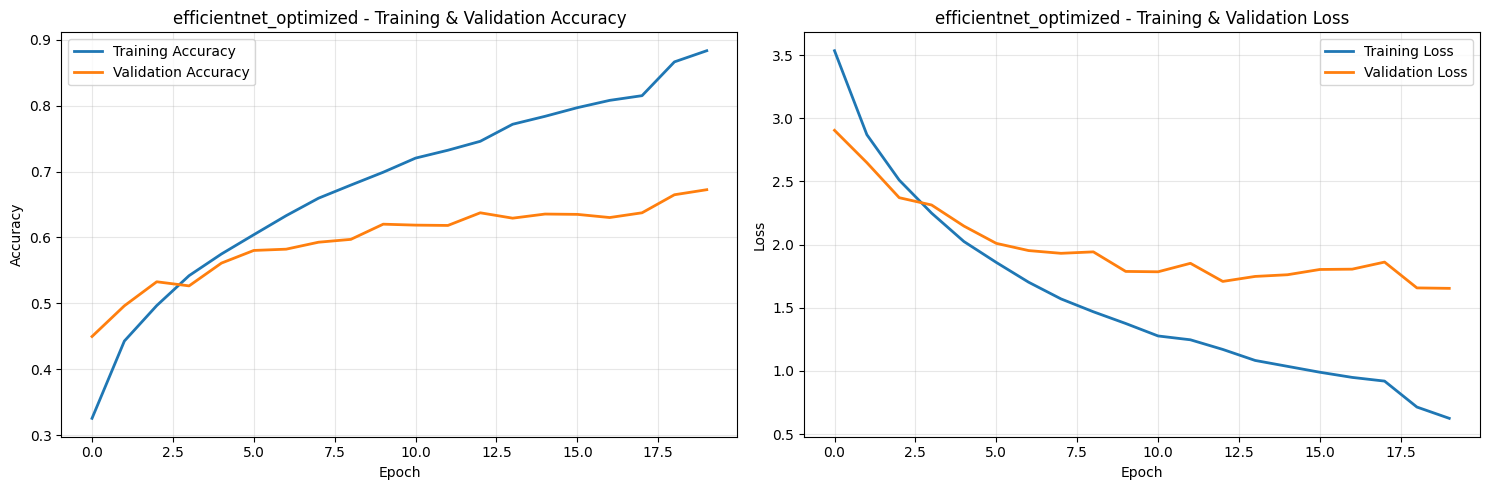


Test Accuracy: 0.6714
Test Loss: 1.6458


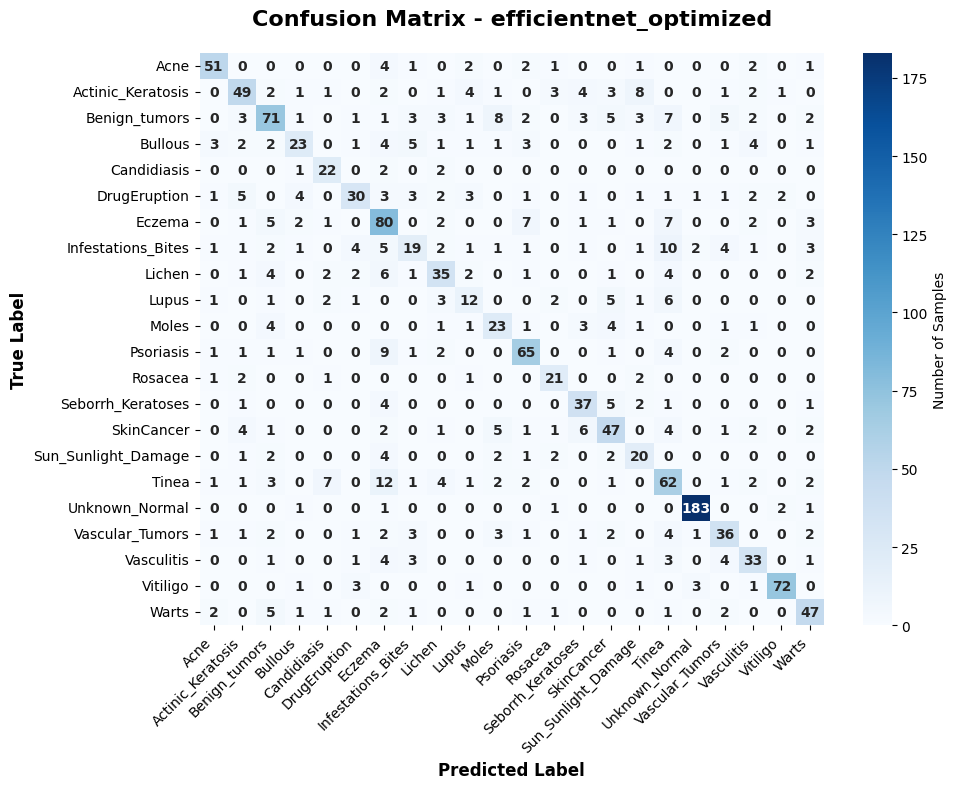


CLASSIFICATION REPORT - EFFICIENTNET_OPTIMIZED

Detailed Report:


,precision,recall,f1-score,support
Acne,0.8095,0.7846,0.7969,65.0000
Actinic_Keratosis,0.6712,0.5904,0.6282,83.0000
Benign_tumors,0.6698,0.5868,0.6256,121.0000
Bullous,0.6216,0.4182,0.5000,55.0000
Candidiasis,0.5946,0.8148,0.6875,27.0000
DrugEruption,0.6818,0.4918,0.5714,61.0000
Eczema,0.5442,0.7143,0.6178,112.0000
Infestations_Bites,0.4634,0.3167,0.3762,60.0000
Lichen,0.5932,0.5738,0.5833,61.0000
Lupus,0.4000,0.3529,0.3750,34.0000



Overall Accuracy: 0.6714

Macro Average:
  Precision: 0.6361
  Recall:    0.6389
  F1-Score:  0.6327

Weighted Average:
  Precision: 0.6750
  Recall:    0.6714
  F1-Score:  0.6692

Model saved as: outputs/models/efficientnet_optimized_final.keras

=== EFFICIENTNET TRAINING COMPLETED ===
Final Test Accuracy: 0.6714
Training completed in 20 epochs
Total Parameters: 4,845,497
Trainable Parameters: 3,099,686
Non-trainable Parameters: 1,745,811
Final Validation Accuracy: 0.6724


In [ ]:
# %% [train-efficientnet]
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from pathlib import Path

PREP_DIR = Path('./outputs/skindisease_preprocessed')
IMG_SIZE = (224,224)

if (PREP_DIR/'train').exists():
    tmp_flow = ImageDataGenerator().flow_from_directory(PREP_DIR/'train', target_size=IMG_SIZE, batch_size=1, class_mode='categorical')
    n_classes = tmp_flow.num_classes
    print(f"Number of classes detected: {n_classes}")
else:
    n_classes = 2
    print("Using fallback number of classes: 2")


print("Building Optimized EfficientNetB0 Model...")
effnet_model, effnet_prep = build_efficientnet_model(IMG_SIZE, n_classes)
print("Model Architecture Summary:")
effnet_model.summary()


print("\nStarting EfficientNet Model Training...")
effnet_model, effnet_results = train_efficientnet_model(
    effnet_model,
    effnet_prep,
    model_tag='efficientnet_optimized',
    epochs=20,
    lr=1e-3
)

print(f"\n=== EFFICIENTNET TRAINING COMPLETED ===")
print(f"Final Test Accuracy: {effnet_results['test_accuracy']:.4f}")
print(f"Training completed in {effnet_results['training_epochs']} epochs")
print(f"Total Parameters: {effnet_results['total_parameters']:,}")
print(f"Trainable Parameters: {effnet_results['trainable_parameters']:,}")
print(f"Non-trainable Parameters: {effnet_results['non_trainable_parameters']:,}")
print(f"Final Validation Accuracy: {effnet_results['final_val_accuracy']:.4f}")